In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM , Dense , GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
import os
directories = [
    "/Users/evangelosgeraridis/Desktop/MEAZON/September 2022",
    "/Users/evangelosgeraridis/Desktop/MEAZON/October 2022"
]

dataframes = {}

for directory in directories:
    files = os.listdir(directory)
    for file in files:
        if file.enwhwith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            dataframes[file] = df

In [3]:
fridge_data = pd.concat([dataframes['fridgeS.csv'], dataframes['fridgeO.csv']], ignore_index=True)
aggregated_data = pd.concat([dataframes['Aggregatewh.csv'], dataframes['AggregatedO.csv']], ignore_index=True)
dishwasher_data = pd.concat([dataframes['dishwasherS.csv'], dataframes['dishwasherO.csv']], ignore_index=True)
hotplate_data = pd.concat([dataframes['hotplateS.csv'], dataframes['hotplateO.csv']], ignore_index=True)
microwave_data = pd.concat([dataframes['microwaveS.csv'], dataframes['microwaveO.csv']], ignore_index=True)
washing_machine_data = pd.concat([dataframes['washing_machineS.csv'], dataframes['washing_machineO.csv']], ignore_index=True)
water_heater_data = pd.concat([dataframes['water_heaterS.csv'], dataframes['water_heaterO.csv']], ignore_index=True)

data_list = [fridge_data, aggregated_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data]
 
data_train = []
data_test = []

for i in range(len(data_list)):
    data_list[i] = data_list[i].set_index('ts')
    data_list[i] = data_list[i].dropna()
    data_train.append(data_list[i].iloc[:43800])
    data_test.append(data_list[i].iloc[43800:65700]) # because the meazon dataset takes one sample per minute, in normal circumstances
                                                 # (for more info about meazon datasets visit this link: 
                                                    # https://drive.google.com/file/d/18rZBQd6BHi_NpDkktm-BR6aHaud6aK6B/view?usp=sharing)
                                              # we will take as train dataset about a month of data (about 43800 entries)
                                                # and then try to predict the next 15 days about 21900 entries to the future 
                                 
fridge_train, aggregated_train , dishwasher_train, hotplate_train, microwave_train, washing_machine_train, water_heater_train = data_train
fridge_test,aggregated_test, dishwasher_test, hotplate_test, microwave_test, washing_machine_test, water_heater_test = data_test

In [3]:
fridge_train

pwrA    apwrA   curA     vltA  screA
ts                                                    
1661979617939  126.163  200.320  0.912  220.036  0.754
1661979677939  126.112  200.100  0.913  219.542  0.753
1661979737939  126.236  199.859  0.911  219.856  0.760
1661979797939  126.321  200.896  0.915  220.039  0.755
1661979857939  126.341  202.959  0.922  220.450  0.786
...                ...      ...    ...      ...    ...
1663408203895   14.927   15.104  0.069  220.795  0.705
1663408203945   14.928   14.991  0.068  220.790  0.712
1663408203995   14.853   14.986  0.068  220.804  0.692
1663408204045   14.791   14.902  0.068  220.773  0.714
1663408204095   14.782   14.817  0.067  220.812  0.698

[43800 rows x 5 columns]

In [4]:
fridge_test

pwrA   apwrA   curA     vltA  screA
ts                                                  
1663408204145  14.759  14.960  0.068  220.818  0.989
1663408204195  14.795  14.795  0.067  220.775  0.709
1663408204245  14.787  14.938  0.068  220.772  0.699
1663408204295  14.853  15.078  0.068  220.740  1.112
1663408204345  14.942  15.040  0.068  220.733  0.687
...               ...     ...    ...      ...    ...
1663991211248  15.806  15.965  0.070  227.076  0.701
1663991271248  15.317  15.347  0.068  226.148  0.713
1663991331248  15.404  15.479  0.069  226.151  0.716
1663991391248  15.454  15.572  0.069  225.987  0.811
1663991451248  15.378  15.445  0.069  225.699  0.695

[21900 rows x 5 columns]

In [4]:
aggregated_train

pwrA     apwrA   curA     vltA  screA
ts                                                      
1661979608509   520.140   528.737  2.402  220.069  1.654
1661979668509   538.722   547.633  2.492  219.749  1.507
1661979728510   555.066   560.574  2.545  220.197  1.575
1661979788510   496.945   503.258  2.286  220.177  1.609
1661979848511   486.377   494.527  2.245  220.217  1.569
...                 ...       ...    ...      ...    ...
1662300726676  1797.428  1799.936  8.226  218.788  1.406
1662300726726  1797.697  1799.219  8.222  218.795  1.407
1662300726776  1797.652  1798.906  8.221  218.802  1.407
1662300726826  1798.458  1799.085  8.221  218.802  1.407
1662300726876  1797.876  1799.219  8.222  218.803  1.416

[43800 rows x 5 columns]

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fridge_scaled_train = scaler.fit_transform(fridge_train)
aggregated_scaled_train = scaler.fit_transform(aggregated_train)
microwave_scaled_train = scaler.fit_transform(microwave_train)
washing_machine_scaled_train = scaler.fit_transform(washing_machine_train)
hotplate_scaled_train = scaler. fit_transform(hotplate_train)
water_heater_scaled_train = scaler.fit_transform(water_heater_train)
dishwasher_scaled_train = scaler.fit_transform(dishwasher_train)

fridge_scaled_test = scaler.fit_transform(fridge_test)
aggregated_scaled_test = scaler.fit_transform(aggregated_test)
microwave_scaled_test = scaler.fit_transform(microwave_test)
washing_machine_scaled_test = scaler.fit_transform(washing_machine_test)
hotplate_scaled_test = scaler. fit_transform(hotplate_test)
water_heater_scaled_test = scaler.fit_transform(water_heater_test)
dishwasher_scaled_test = scaler.fit_transform(dishwasher_test)



In [6]:
# let us begin with fridge data 
from tensorflow.keras.callbacks import ModelCheckpoint

length = 15

batch_size = 5

train_generator_fridge = TimeseriesGenerator(aggregated_scaled_train, fridge_scaled_train , length=length, batch_size=batch_size)
validation_generator_fridge = TimeseriesGenerator(aggregated_scaled_test, fridge_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_fridge = Sequential()
model_fridge.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_fridge.add(LSTM(32, return_sequences= True))
model_fridge.add(Dropout(0.5))
model_fridge.add(LSTM(8))
model_fridge.add(Dropout(0.5))
model_fridge.add(Dense(5))

model_fridge.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_fridge.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=4)
checkpoint = ModelCheckpoint("model_fridge_checkpoint.h5", save_best_only=True)

# Train the model
history_fridge = model_fridge.fit(train_generator_fridge, epochs=6, validation_data=validation_generator_fridge, callbacks=[early_stop,checkpoint])

Metal device set to: Apple M1


2023-06-10 18:07:34.978515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-10 18:07:34.979061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            12416     
                                                                 
 dropout (Dropout)           (None, 15, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-traina

2023-06-10 18:07:35.444700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-10 18:07:36.318093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:07:36.672994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:07:36.803451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:07:36.993644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:07:37.152482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8757/8757 [==============================] - ETA: 0s - loss: 0.0235 - mse: 0.0235 - mae: 0.0926 - accuracy: 0.9061

2023-06-10 18:39:56.455258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:39:56.593269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 18:39:56.666369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8757/8757 [==============================] - 2072s 236ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.0926 - accuracy: 0.9061 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.0894 - val_accuracy: 0.8960
Epoch 2/6
8757/8757 [==============================] - 2106s 241ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.0901 - accuracy: 0.9077 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.0921 - val_accuracy: 0.8960
Epoch 3/6
8757/8757 [==============================] - 2075s 237ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.0898 - accuracy: 0.9077 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.0893 - val_accuracy: 0.8960
Epoch 4/6
8757/8757 [==============================] - 2158s 246ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.0896 - accuracy: 0.9077 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.0911 - val_accuracy: 0.8960
Epoch 5/6
8757/8757 [==============================] - 2167s 247ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.0895 - accuracy: 0.9077 - val_loss: 0.0232 - val_mse

In [7]:
model_fridge.save("/Users/evangelosgeraridis/Desktop/MEAZON/models/model_fridge.h5")

In [8]:

n_features_f = 5  # Number of aggregated features

test_predictions_f = []


first_eval_batch_f = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_f = first_eval_batch_f.reshape((1, length, n_features_f))

current_batch_f = first_eval_batch_f

for i in range(len(fridge_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_f = model_fridge.predict(current_batch_f)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_f.append(current_pred_f)

    # Update the batch to include the prediction and drop the first value
    current_batch_f = np.append(current_batch_f[:, 1:, :], [[current_pred_f]], axis=1)

2023-06-10 21:42:50.479373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 21:42:50.640994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step


2023-06-10 21:42:50.733193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 43ms/step


In [10]:
test_predictions_f = pd.DataFrame(test_predictions_f)
test_predictions_f.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']

In [12]:
true_predictions_fridge = scaler.inverse_transform(test_predictions_f)

In [14]:
true_predictions_fridge = pd.DataFrame(true_predictions_fridge)

In [17]:
true_predictions_fridge.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
true_predictions_fridge

predicted_fridge_active_power  predicted_fridge_apparent_power   
0                         193.251923                       247.899658  \
1                         192.898712                       247.897125   
2                         192.566742                       247.914978   
3                         192.260880                       247.940781   
4                         191.982315                       247.970856   
...                              ...                              ...   
21895                     190.204849                       248.351593   
21896                     190.204849                       248.351593   
21897                     190.204849                       248.351593   
21898                     190.204849                       248.351593   
21899                     190.204849                       248.351593   

       predicted_fridge_current  predicted_fridge_voltage   
0                      1.166516                221.488388  \
1                      1.167401                221.484818   
2                      1.168222                221.481659   
3                      1.168935                221.478729   
4                      1.169542                221.475952   
...                         ...                       ...   
21895                  1.171953                221.453903   
21896                  1.171953                221.453903   
21897                  1.171953                221.453903   
21898                  1.171953                221.453903   
21899                  1.171953                221.453903   

       predicted_fridge_crest_factor  
0                           0.808687  
1                           0.808537  
2                           0.808389  
3                           0.808248  
4                           0.808115  
...                              ...  
21895                       0.807178  
21896                       0.807178  
21897                       0.807178  
21898                       0.807178  
21899                       0.807178  

[21900 rows x 5 columns]

In [18]:
fridge_test

pwrA   apwrA   curA     vltA  screA
ts                                                  
1663408204145  14.759  14.960  0.068  220.818  0.989
1663408204195  14.795  14.795  0.067  220.775  0.709
1663408204245  14.787  14.938  0.068  220.772  0.699
1663408204295  14.853  15.078  0.068  220.740  1.112
1663408204345  14.942  15.040  0.068  220.733  0.687
...               ...     ...    ...      ...    ...
1663991211248  15.806  15.965  0.070  227.076  0.701
1663991271248  15.317  15.347  0.068  226.148  0.713
1663991331248  15.404  15.479  0.069  226.151  0.716
1663991391248  15.454  15.572  0.069  225.987  0.811
1663991451248  15.378  15.445  0.069  225.699  0.695

[21900 rows x 5 columns]

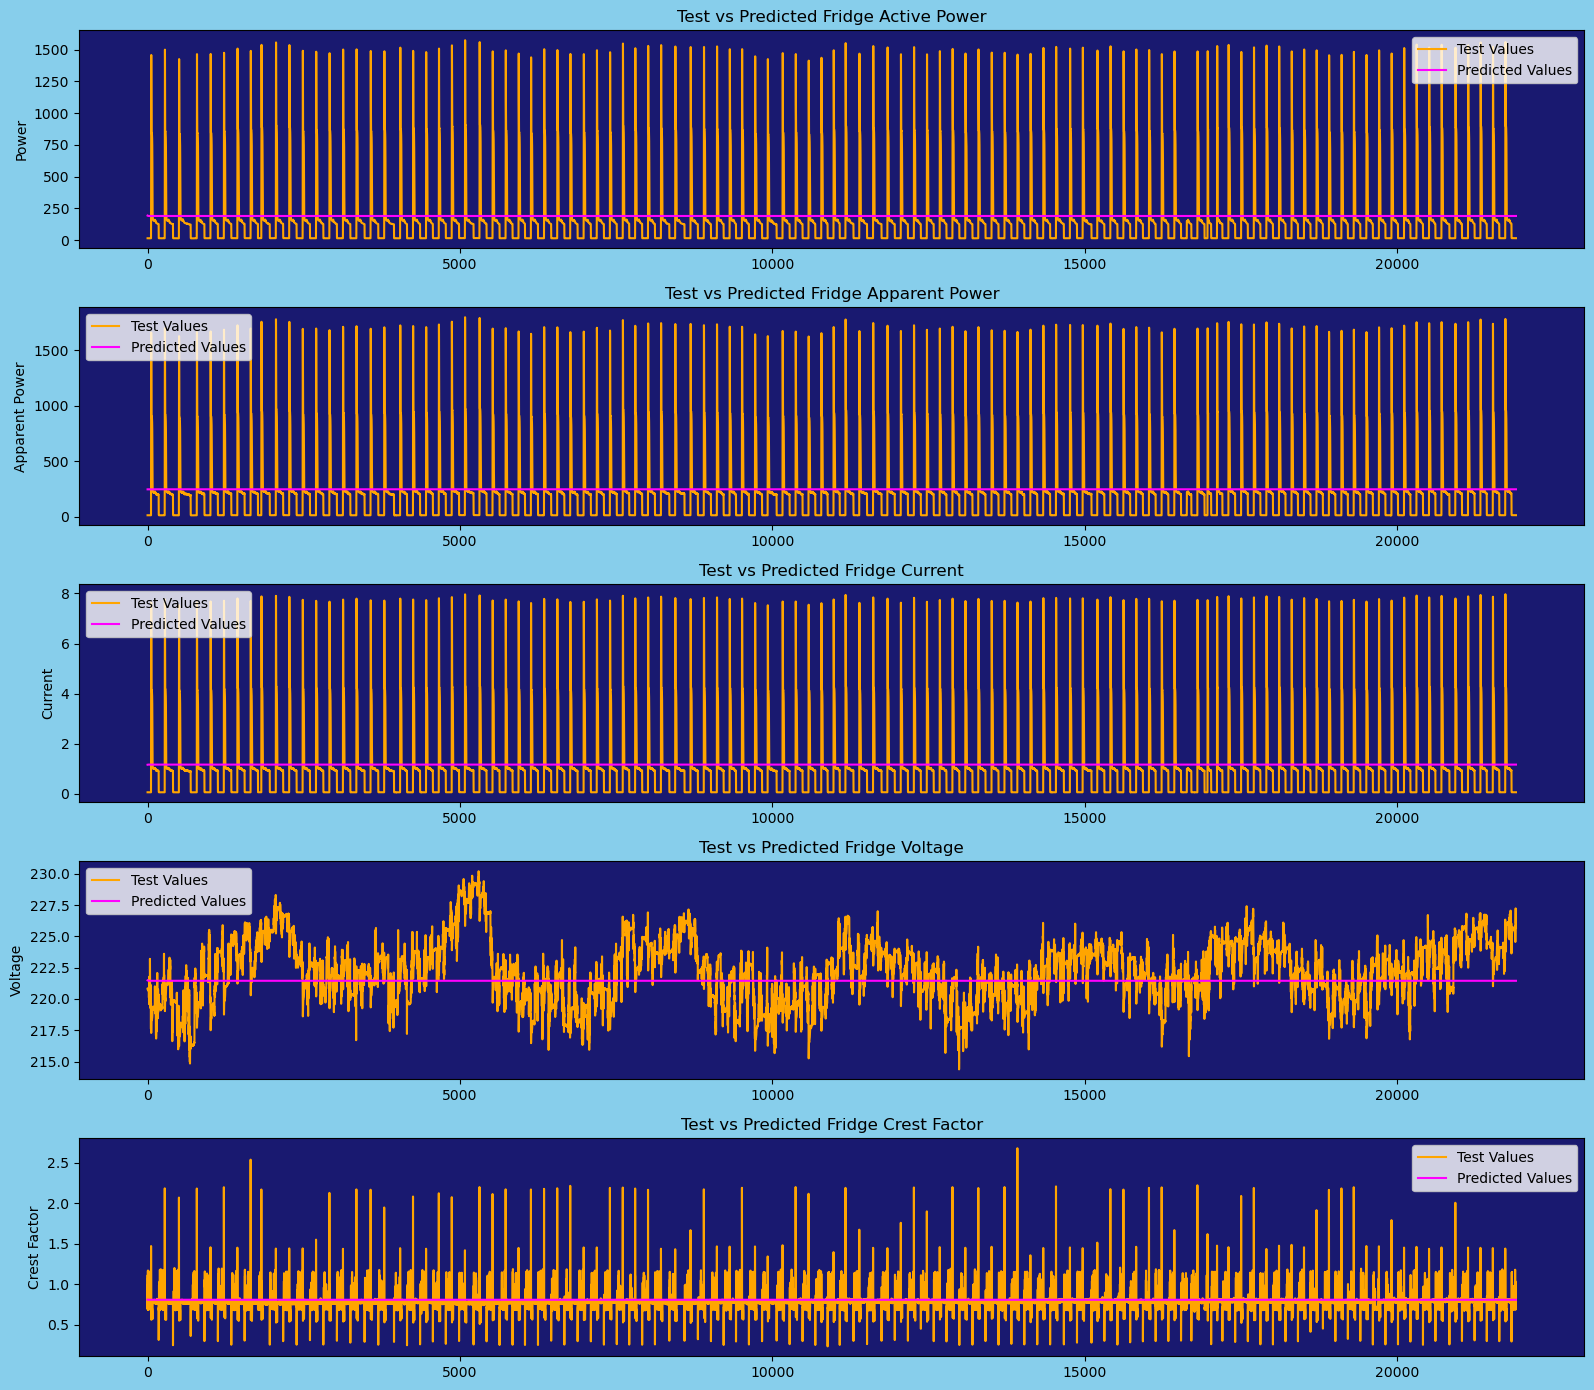

In [27]:
import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = fridge_test['pwrA'].values
apwrA = fridge_test['apwrA'].values
curA = fridge_test['curA'].values
vltA = fridge_test['vltA'].values
screA = fridge_test['screA'].values

predicted_pwrA = true_predictions_fridge['predicted_fridge_active_power'].values
predicted_apwrA = true_predictions_fridge['predicted_fridge_apparent_power'].values
predicted_curA = true_predictions_fridge['predicted_fridge_current'].values
predicted_vltA = true_predictions_fridge['predicted_fridge_voltage'].values
predicted_screA = true_predictions_fridge['predicted_fridge_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted Fridge Active Power')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted Fridge Apparent Power')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted Fridge Current')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted Fridge Voltage')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted Fridge Crest Factor')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [12]:
fridge_scaled_train[-7200:,:]

array([[1.34539439e-03, 9.21867626e-04, 7.62679547e-04, 7.53558327e-01,
        1.75066313e-01],
       [1.22677793e-03, 8.47350463e-04, 6.35566290e-04, 7.52457814e-01,
        2.51231527e-01],
       [1.27835030e-03, 8.69366898e-04, 6.35566290e-04, 7.48862803e-01,
        1.74308450e-01],
       ...,
       [8.88334199e-04, 5.51539908e-04, 5.08453032e-04, 4.42333089e-01,
        1.75066313e-01],
       [8.48365607e-04, 5.04119896e-04, 5.08453032e-04, 4.40058694e-01,
        1.83402804e-01],
       [8.42563714e-04, 4.56135359e-04, 3.81339774e-04, 4.42920029e-01,
        1.77339901e-01]])

In [4]:
# we see that by training on about a months data the next 15 days of predictions were stable without any pattern emerging like
# when we saw by training and testing on the exact timestamps of the data
# now we will try to train on a sample of train and we will test them on about 2 days in the future. If we sample about 1 per minute
# this means that we will need 2880 entries to the future. Note that here we could not take a length of 1440 which would be about 
# a days worth of data and by setting the length on 10 surely impacted negatively our model. That being said we will try to limit 
# our taining data by sampling in order to increase the length and be able to train the model given our resources.
fridge_scaled_train = fridge_scaled_train[-7200:,:]
fridge_scaled_test = fridge_scaled_test[:2880,:]

In [5]:
aggregated_scaled_train = aggregated_scaled_train[-7200:,:]
aggregated_scaled_test = aggregated_scaled_test[:2880,:]

In [16]:
# let us begin with fridge data 
from tensorflow.keras.callbacks import ModelCheckpoint

length = 60

batch_size = 12

train_generator_fridge = TimeseriesGenerator(aggregated_scaled_train, fridge_scaled_train , length=length, batch_size=batch_size)
validation_generator_fridge = TimeseriesGenerator(aggregated_scaled_test, fridge_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_fridge = Sequential()
model_fridge.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_fridge.add(LSTM(32, return_sequences= True))
model_fridge.add(Dropout(0.5))
model_fridge.add(LSTM(8))
model_fridge.add(Dropout(0.5))
model_fridge.add(Dense(5))

model_fridge.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_fridge.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=1)
checkpoint = ModelCheckpoint("model_fridge_checkpoint.h5", save_best_only=True)

# Train the model
history_fridge = model_fridge.fit(train_generator_fridge, epochs=1, validation_data=validation_generator_fridge, callbacks=[early_stop,checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 64)            17920     
                                                                 
 lstm_7 (LSTM)               (None, 60, 32)            12416     
                                                                 
 dropout_4 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-trai

2023-06-10 22:54:42.270844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 22:54:42.856752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 22:54:43.024219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 22:54:43.301157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 22:54:43.631185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0295 - mae: 0.1113 - accuracy: 0.8803

2023-06-10 23:27:00.040568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 23:27:00.287387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-10 23:27:00.420317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - 1980s 3s/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1113 - accuracy: 0.8803 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1005 - val_accuracy: 0.8695


In [18]:

n_features_f = 5  # Number of aggregated features

test_predictions_f = []


first_eval_batch_f = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_f = first_eval_batch_f.reshape((1, length, n_features_f))

current_batch_f = first_eval_batch_f

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_f = model_fridge.predict(current_batch_f)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_f.append(current_pred_f)

    # Update the batch to include the prediction and drop the first value
    current_batch_f = np.append(current_batch_f[:, 1:, :], [[current_pred_f]], axis=1)

1/1 [==============================] - 0s 182ms/step


In [21]:
test_predictions_f = pd.DataFrame(test_predictions_f)
true_predictions_fridge = scaler.inverse_transform(test_predictions_f)
true_predictions_fridge = pd.DataFrame(true_predictions_fridge)

true_predictions_fridge.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
true_predictions_fridge

predicted_fridge_active_power  predicted_fridge_apparent_power   
0                        240.572144                        74.293358  \
1                        241.017029                        74.707520   
2                        241.273087                        75.913910   
3                        241.437378                        77.702446   
4                        241.535889                        79.836815   
...                             ...                              ...   
2795                     230.998566                        98.524658   
2796                     230.998535                        98.524666   
2797                     230.998535                        98.524651   
2798                     230.998505                        98.524673   
2799                     230.998505                        98.524658   

      predicted_fridge_current  predicted_fridge_voltage   
0                     0.147727                220.706818  \
1                     0.153560                220.709442   
2                     0.165365                220.712158   
3                     0.181378                220.714981   
4                     0.199764                220.717453   
...                        ...                       ...   
2795                  0.336444                220.631989   
2796                  0.336443                220.631989   
2797                  0.336443                220.631989   
2798                  0.336443                220.631989   
2799                  0.336443                220.631989   

      predicted_fridge_crest_factor  
0                          0.837484  
1                          0.838108  
2                          0.838737  
3                          0.839458  
4                          0.840231  
...                             ...  
2795                       0.827882  
2796                       0.827882  
2797                       0.827882  
2798                       0.827882  
2799                       0.827882  

[2800 rows x 5 columns]

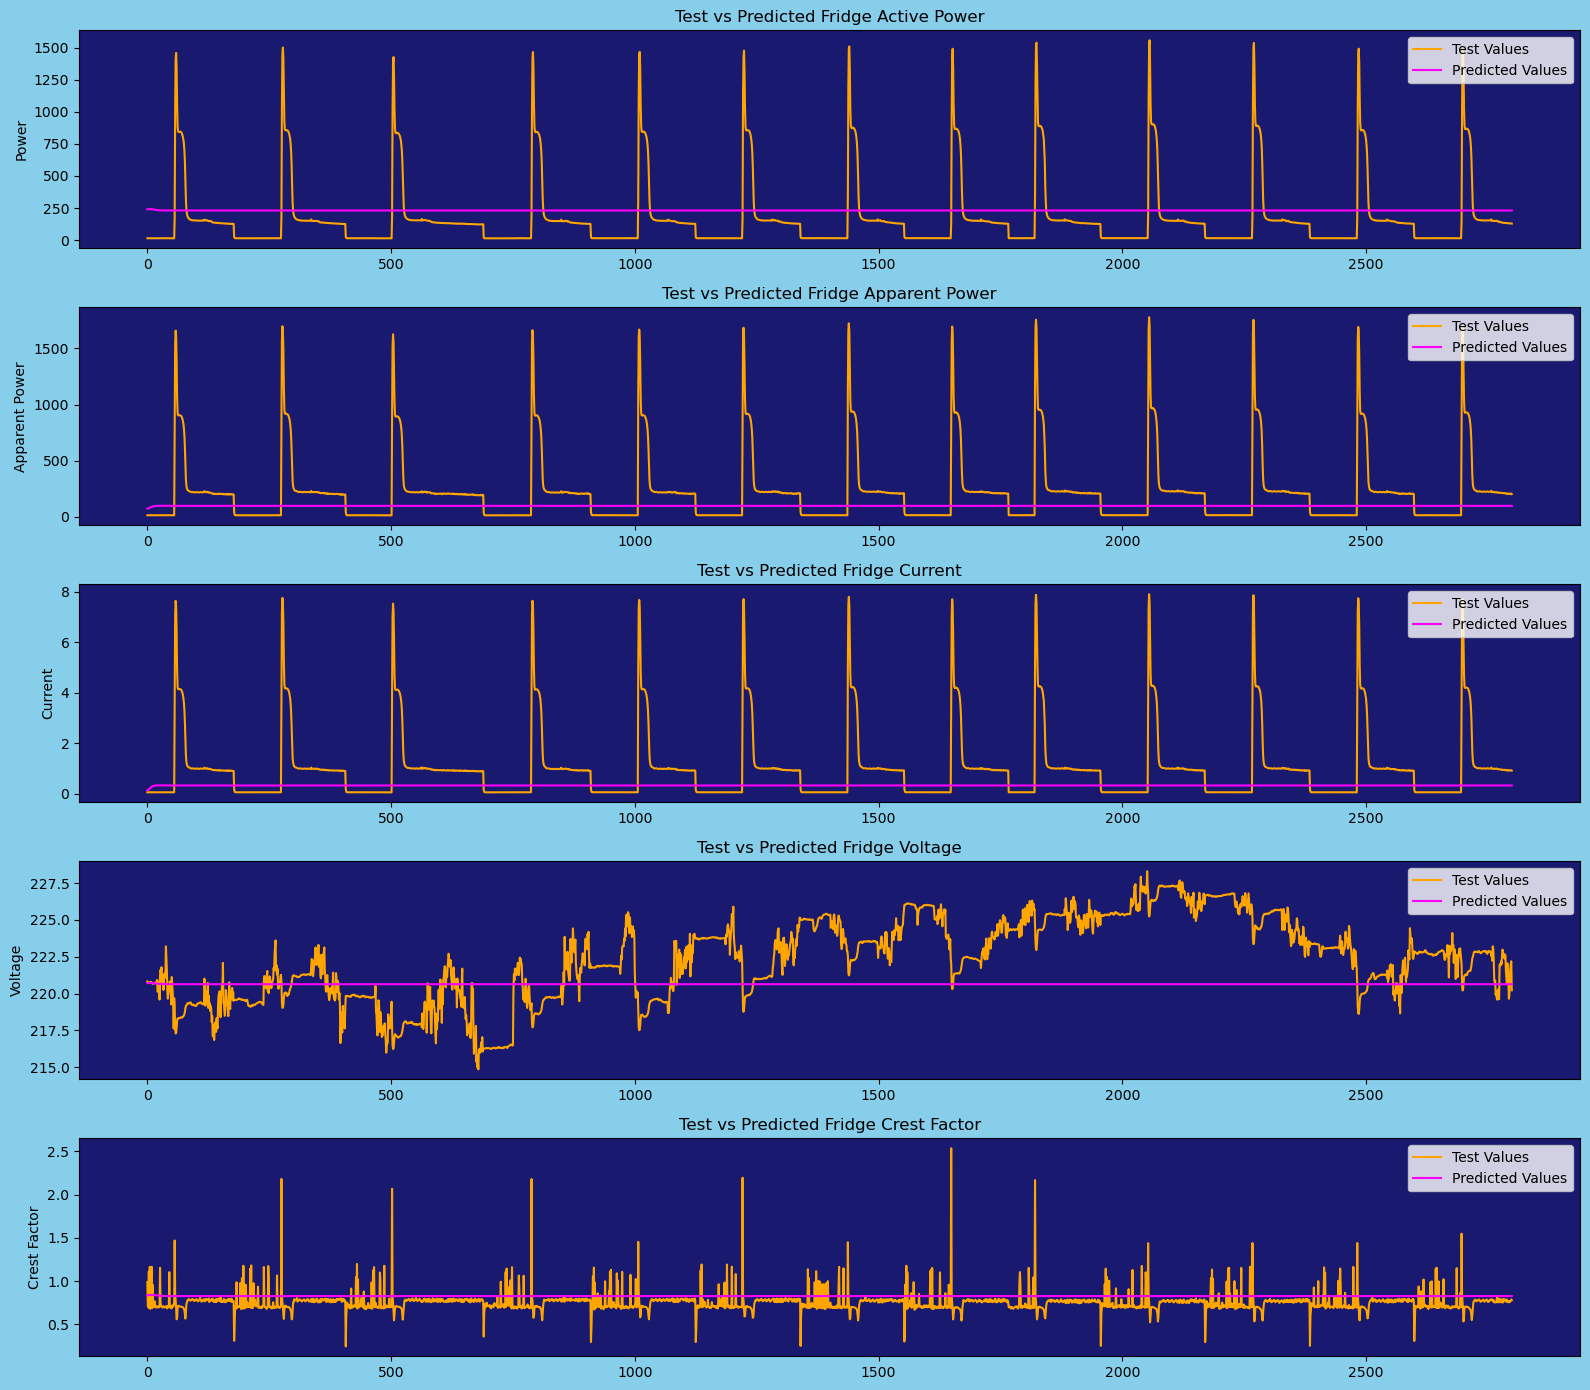

In [23]:
import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = fridge_test['pwrA'].iloc[:2800].values
apwrA = fridge_test['apwrA'].iloc[:2800].values
curA = fridge_test['curA'].iloc[:2800].values
vltA = fridge_test['vltA'].iloc[:2800].values
screA = fridge_test['screA'].iloc[:2800].values

predicted_pwrA = true_predictions_fridge['predicted_fridge_active_power'].values
predicted_apwrA = true_predictions_fridge['predicted_fridge_apparent_power'].values
predicted_curA = true_predictions_fridge['predicted_fridge_current'].values
predicted_vltA = true_predictions_fridge['predicted_fridge_voltage'].values
predicted_screA = true_predictions_fridge['predicted_fridge_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted Fridge Active Power')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted Fridge Apparent Power')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted Fridge Current')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted Fridge Voltage')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted Fridge Crest Factor')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [6]:
washing_machine_scaled_train = washing_machine_scaled_train[-7200:,:]
washing_machine_scaled_test = washing_machine_scaled_test[:2880,:]

In [8]:
# washing_machine data 

length = 60

batch_size = 10

train_generator_washing_machine = TimeseriesGenerator(aggregated_scaled_train, washing_machine_scaled_train , length=length, batch_size=batch_size)
validation_generator_washing_machine = TimeseriesGenerator(aggregated_scaled_test, washing_machine_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_washing_machine = Sequential()
model_washing_machine.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_washing_machine.add(LSTM(32, return_sequences= True))
model_washing_machine.add(Dropout(0.5))
model_washing_machine.add(LSTM(8))
model_washing_machine.add(Dropout(0.5))
model_washing_machine.add(Dense(5))

model_washing_machine.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_washing_machine.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history_washing_machine = model_washing_machine.fit(train_generator_washing_machine, epochs=4, validation_data=validation_generator_washing_machine, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 64)            17920     
                                                                 
 lstm_4 (LSTM)               (None, 60, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-trai

2023-06-11 19:12:38.262367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:12:39.402938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:12:39.733241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:12:40.155229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 19:12:40.727928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - ETA: 0s - loss: 0.1266 - mse: 0.1266 - mae: 0.2862 - accuracy: 0.5943

2023-06-11 20:13:53.054893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 20:13:53.478463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 20:13:53.694813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - 3757s 5s/step - loss: 0.1266 - mse: 0.1266 - mae: 0.2862 - accuracy: 0.5943 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2321 - val_accuracy: 0.8933
Epoch 2/4
714/714 [==============================] - 3857s 5s/step - loss: 0.0837 - mse: 0.0837 - mae: 0.2148 - accuracy: 0.6342 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1430 - val_accuracy: 0.9323
Epoch 3/4
714/714 [==============================] - 4669s 7s/step - loss: 0.0632 - mse: 0.0632 - mae: 0.1694 - accuracy: 0.6352 - val_loss: 0.0565 - val_mse: 0.0565 - val_mae: 0.1465 - val_accuracy: 0.9199
Epoch 4/4
714/714 [==============================] - 2433s 3s/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1374 - accuracy: 0.6605 - val_loss: 0.0553 - val_mse: 0.0553 - val_mae: 0.1424 - val_accuracy: 0.9188


In [10]:

n_features_wm = 5  # Number of aggregated features

test_predictions_wm = []


first_eval_batch_wm = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_wm = first_eval_batch_wm.reshape((1, length, n_features_wm))

current_batch_wm = first_eval_batch_wm

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_wm = model_washing_machine.predict(current_batch_wm)[0]

    

    # Store the actual prediction
    test_predictions_wm.append(current_pred_wm)

    # Update the batch to include the prediction and drop the first value
    current_batch_wm = np.append(current_batch_wm[:, 1:, :], [[current_pred_wm]], axis=1)

2023-06-11 23:18:45.389977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 23:18:45.657261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 23:18:45.790126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 199ms/step


In [11]:
test_predictions_wm = pd.DataFrame(test_predictions_wm)
true_predictions_washing_machine = scaler.inverse_transform(test_predictions_wm)
true_predictions_washing_machine = pd.DataFrame(true_predictions_washing_machine)

true_predictions_washing_machine.columns = ['predicted_washing_machine_active_power','predicted_washing_machine_apparent_power','predicted_washing_machine_current', 'predicted_washing_machine_voltage', 'predicted_washing_machine_crest_factor']
true_predictions_washing_machine

predicted_washing_machine_active_power   
0                                 -17.247683  \
1                                 -13.985468   
2                                  -8.951640   
3                                  -3.263614   
4                                   1.830227   
...                                      ...   
2795                              -98.108810   
2796                              -98.108810   
2797                              -98.108871   
2798                              -98.108810   
2799                              -98.108810   

      predicted_washing_machine_apparent_power   
0                                   -21.059610  \
1                                   -19.153334   
2                                   -16.376913   
3                                   -12.888833   
4                                    -9.346279   
...                                        ...   
2795                                -66.170456   
2796                                -66.170486   
2797                                -66.170486   
2798                                -66.170486   
2799                                -66.170456   

      predicted_washing_machine_current  predicted_washing_machine_voltage   
0                              0.230289                         224.082474  \
1                              0.246164                         224.095871   
2                              0.264814                         224.094009   
3                              0.283245                         224.074890   
4                              0.297532                         224.037186   
...                                 ...                                ...   
2795                          -0.194943                         223.425354   
2796                          -0.194943                         223.425354   
2797                          -0.194944                         223.425354   
2798                          -0.194943                         223.425354   
2799                          -0.194943                         223.425354   

      predicted_washing_machine_crest_factor  
0                                   0.419995  
1                                   0.421195  
2                                   0.421591  
3                                   0.420880  
4                                   0.418815  
...                                      ...  
2795                                0.367370  
2796                                0.367370  
2797                                0.367370  
2798                                0.367370  
2799                                0.367370  

[2800 rows x 5 columns]

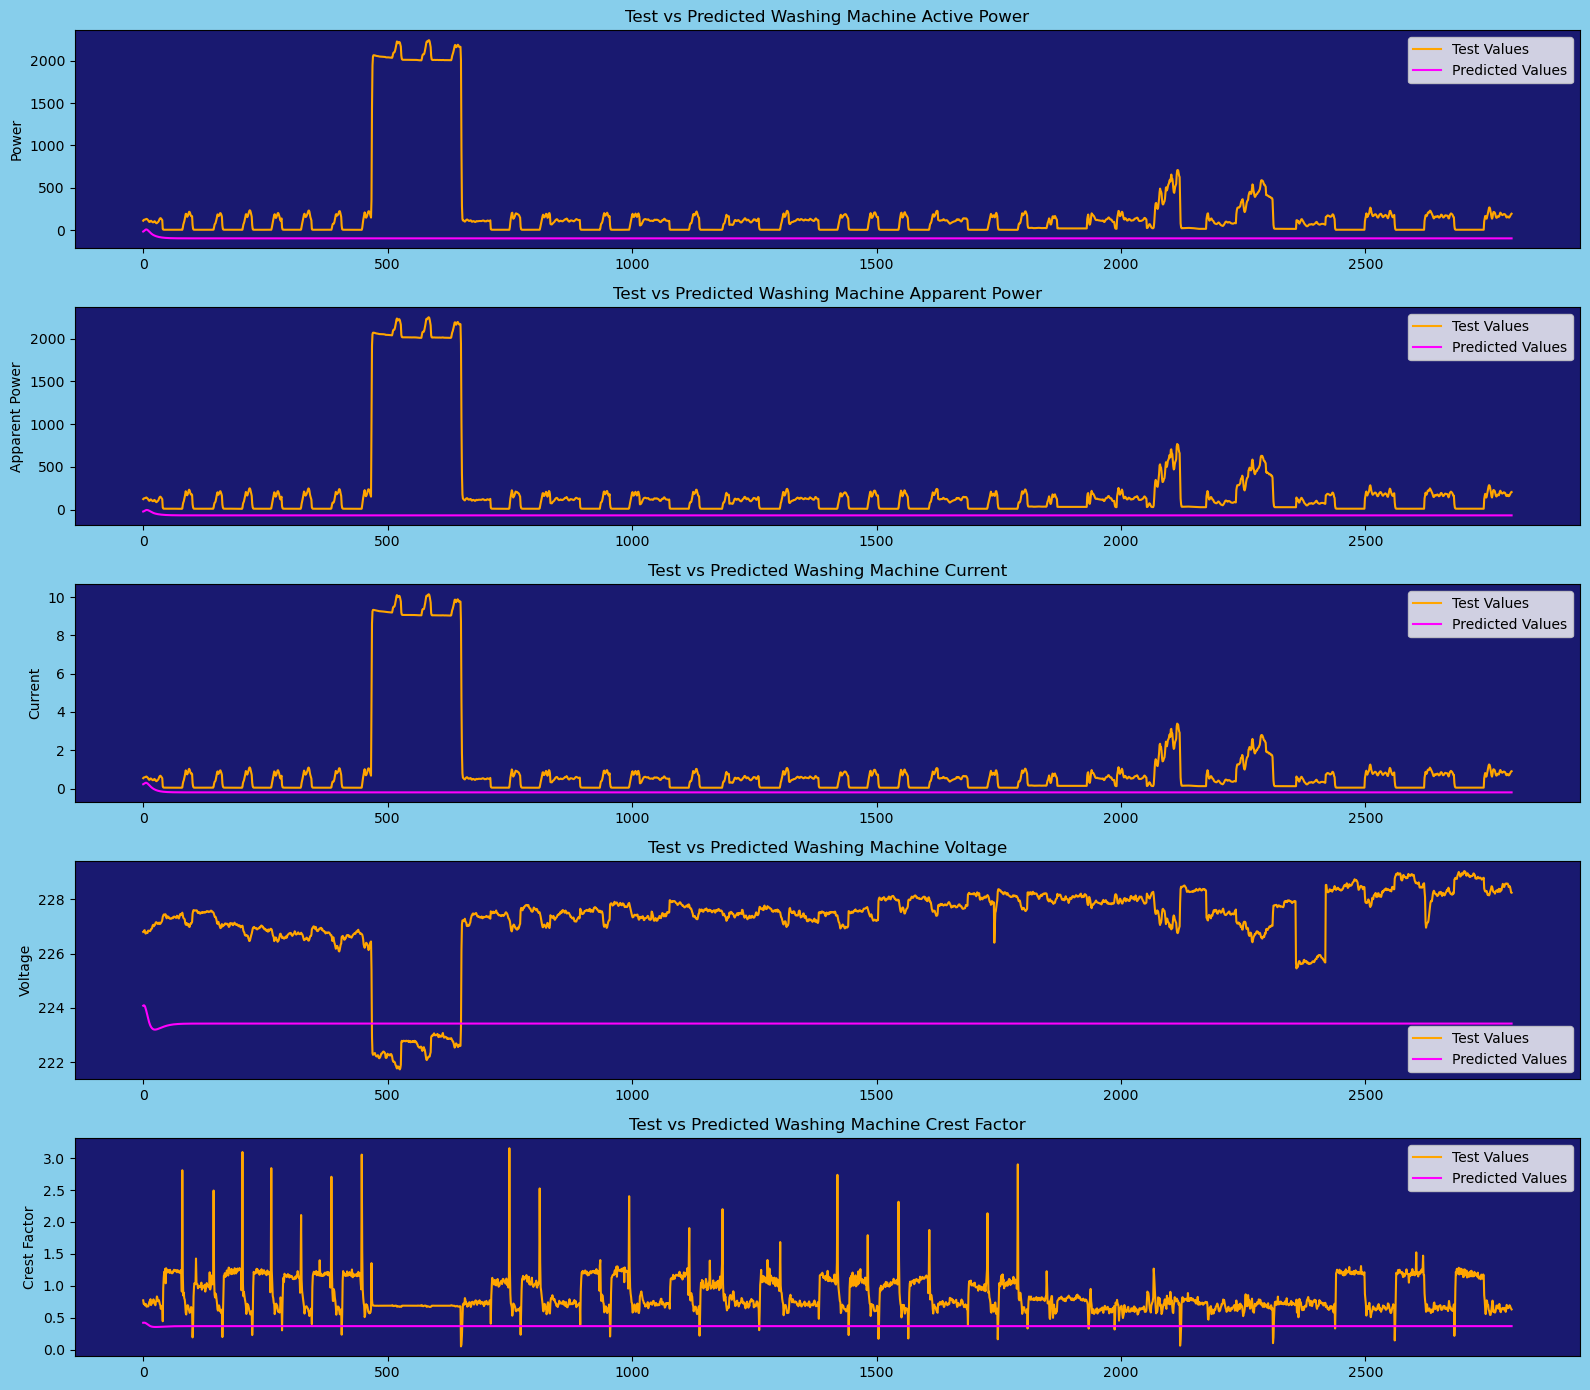

In [13]:
import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = washing_machine_test['pwrA'].iloc[:2800].values
apwrA = washing_machine_test['apwrA'].iloc[:2800].values
curA = washing_machine_test['curA'].iloc[:2800].values
vltA = washing_machine_test['vltA'].iloc[:2800].values
screA =washing_machine_test['screA'].iloc[:2800].values

predicted_pwrA = true_predictions_washing_machine['predicted_washing_machine_active_power'].values
predicted_apwrA = true_predictions_washing_machine['predicted_washing_machine_apparent_power'].values
predicted_curA = true_predictions_washing_machine['predicted_washing_machine_current'].values
predicted_vltA = true_predictions_washing_machine['predicted_washing_machine_voltage'].values
predicted_screA = true_predictions_washing_machine['predicted_washing_machine_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted Washing Machine Active Power')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted Washing Machine Apparent Power')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted Washing Machine Current')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted Washing Machine Voltage')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted Washing Machine Crest Factor')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [16]:
from tensorflow.keras.models import load_model
model_washing_machine.save('/Users/evangelosgeraridis/Desktop/MEAZON/models/model_washing_machine')

INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/model_washing_machine/assets


INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/model_washing_machine/assets


In [7]:
# let us begin with microwave data again 5 last training days (september ) to predict 2 first of October
microwave_scaled_train = microwave_scaled_train[-7200:,:]
microwave_scaled_test = microwave_scaled_test[:2880,:]
from tensorflow.keras.callbacks import ModelCheckpoint

length = 30 # ~ 1/2 hour

batch_size = 5

train_generator_microwave = TimeseriesGenerator(aggregated_scaled_train, microwave_scaled_train , length=length, batch_size=batch_size)
validation_generator_microwave = TimeseriesGenerator(aggregated_scaled_test, microwave_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_microwave = Sequential()
model_microwave.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_microwave.add(LSTM(32, return_sequences= True))
model_microwave.add(Dropout(0.5))
model_microwave.add(LSTM(8))
model_microwave.add(Dropout(0.5))
model_microwave.add(Dense(5))

model_microwave.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model_microwave.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("model_microwave_checkpoint.h5", save_best_only=True)

# Train the model
history_microwave = model_microwave.fit(train_generator_microwave, epochs=4, validation_data=validation_generator_microwave, callbacks=[early_stop,checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            17920     
                                                                 
 lstm_4 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-trai

2023-06-16 21:56:32.916632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 21:56:33.518051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 21:56:33.694374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 21:56:33.958931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 21:56:34.252249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - ETA: 0s - loss: 0.0834 - mse: 0.0834 - mae: 0.2047

2023-06-16 22:29:43.020537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 22:29:43.238693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 22:29:43.359245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - 2047s 1s/step - loss: 0.0834 - mse: 0.0834 - mae: 0.2047 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1497
Epoch 2/4
1434/1434 [==============================] - 2053s 1s/step - loss: 0.0744 - mse: 0.0744 - mae: 0.1937 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.1066
Epoch 3/4
1434/1434 [==============================] - 2206s 2s/step - loss: 0.0748 - mse: 0.0748 - mae: 0.1940 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1422
Epoch 4/4
1434/1434 [==============================] - 2831s 2s/step - loss: 0.0749 - mse: 0.0749 - mae: 0.1953 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1463


In [8]:

n_features_mw = 5  # Number of aggregated features

test_predictions_mw = []


first_eval_batch_mw = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_mw = first_eval_batch_mw.reshape((1, length, n_features_mw))

current_batch_mw = first_eval_batch_mw

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_mw = model_microwave.predict(current_batch_mw)[0]

    

    # Store the actual prediction
    test_predictions_mw.append(current_pred_mw)

    # Update the batch to include the prediction and drop the first value
    current_batch_mw = np.append(current_batch_mw[:, 1:, :], [[current_pred_mw]], axis=1)

2023-06-17 00:28:49.500009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:28:50.210647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:28:51.370576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 118ms/step


In [9]:
test_predictions_mw = pd.DataFrame(test_predictions_mw)
true_predictions_microwave = scaler.inverse_transform(test_predictions_mw)
true_predictions_microwave = pd.DataFrame(true_predictions_microwave)

true_predictions_microwave.columns = ['predicted_microwave_active_power','predicted_microwave_apparent_power','predicted_microwave_current', 'predicted_microwave_voltage', 'predicted_microwave_crest_factor']
true_predictions_microwave

predicted_microwave_active_power  predicted_microwave_apparent_power   
0                           375.950104                          301.782166  \
1                           377.639740                          302.438782   
2                           386.374939                          305.197327   
3                           374.723022                          301.275726   
4                           400.721619                          339.283783   
...                                ...                                 ...   
2795                        368.406036                          377.231934   
2796                        368.406036                          377.231934   
2797                        368.406036                          377.231934   
2798                        368.406036                          377.231934   
2799                        368.406036                          377.231934   

      predicted_microwave_current  predicted_microwave_voltage   
0                        0.664359                   219.751770  \
1                        0.662425                   219.743317   
2                        0.652914                   219.715912   
3                        0.665785                   219.758667   
4                        0.440746                   219.544281   
...                           ...                          ...   
2795                     2.517656                   222.686325   
2796                     2.517656                   222.686325   
2797                     2.517656                   222.686325   
2798                     2.517656                   222.686325   
2799                     2.517656                   222.686325   

      predicted_microwave_crest_factor  
0                             0.925930  
1                             0.927078  
2                             0.933706  
3                             0.925127  
4                             0.985747  
...                                ...  
2795                          0.873777  
2796                          0.873777  
2797                          0.873777  
2798                          0.873777  
2799                          0.873777  

[2800 rows x 5 columns]

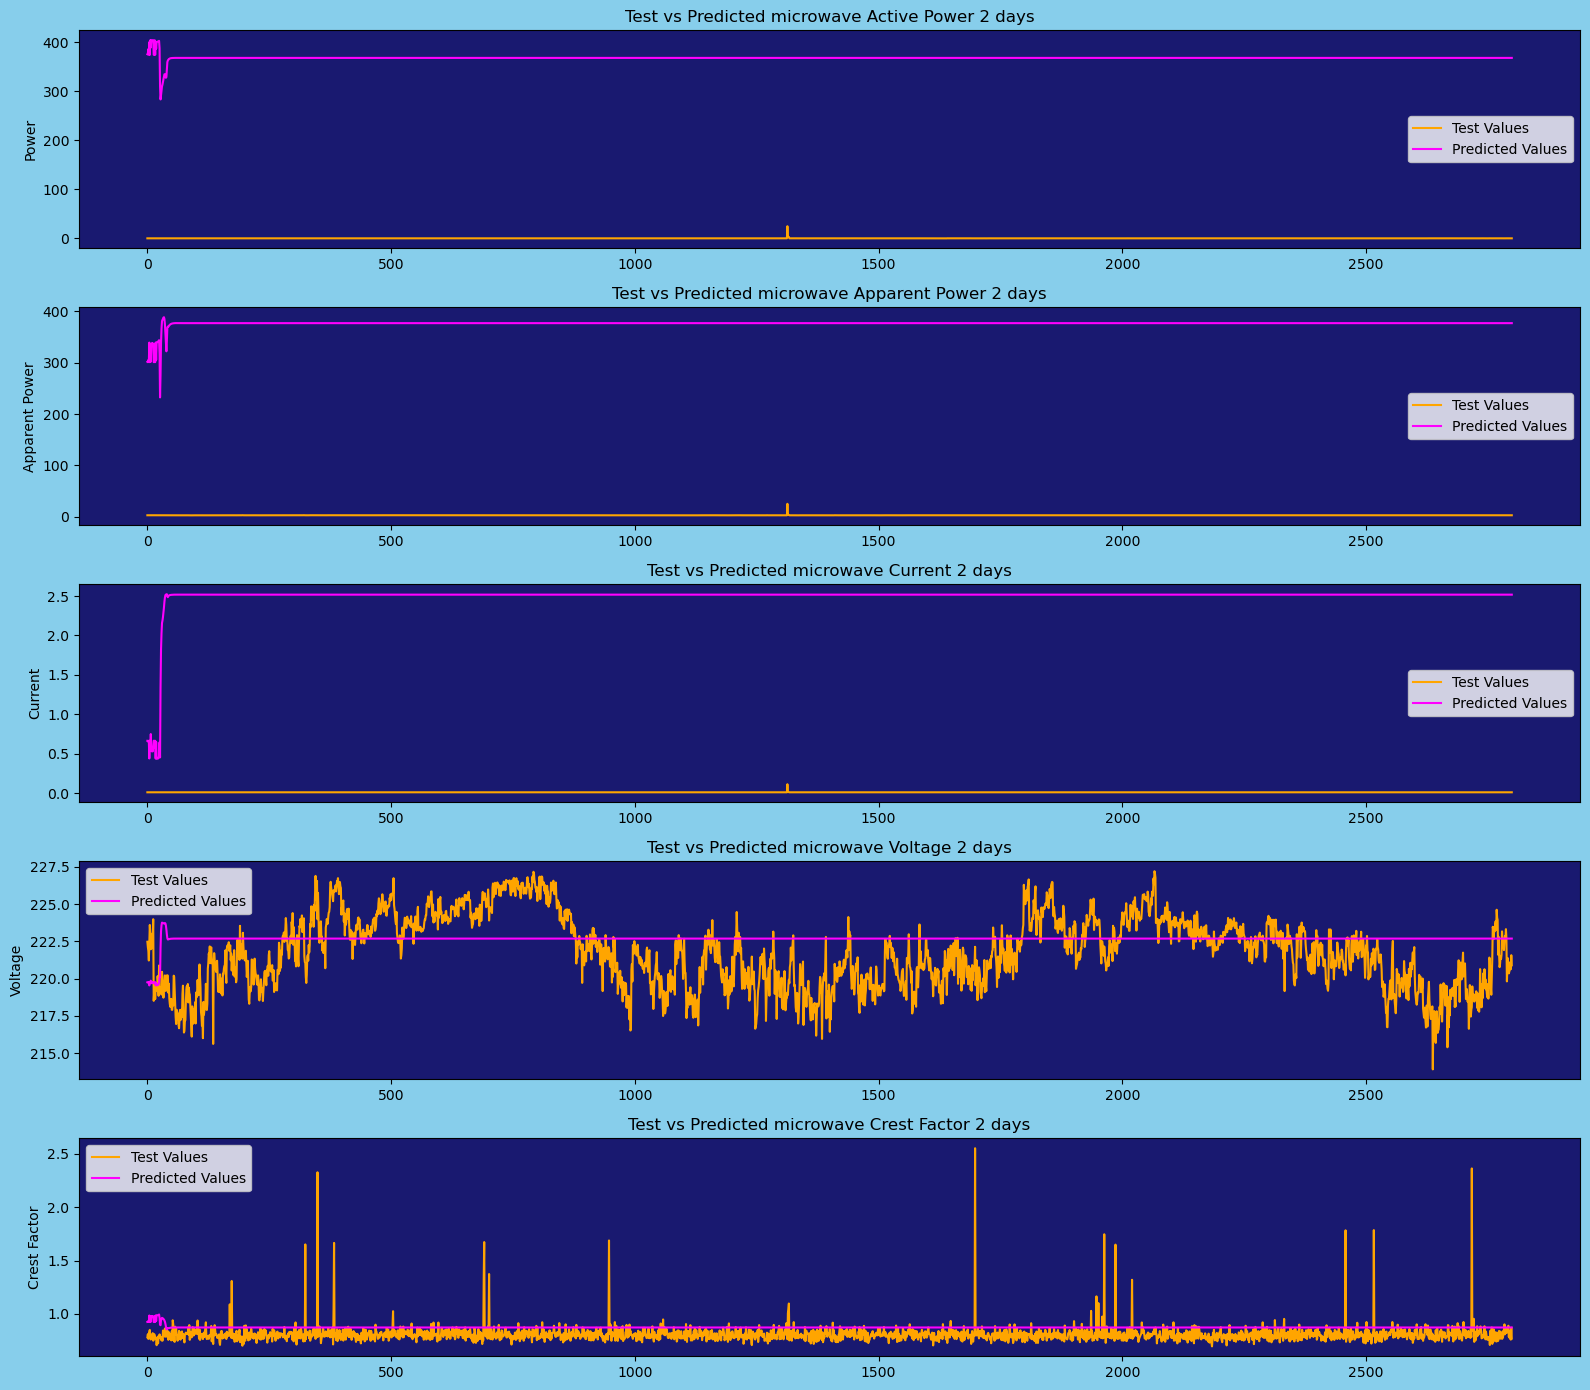

In [10]:
import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = microwave_test['pwrA'].iloc[:2800].values
apwrA = microwave_test['apwrA'].iloc[:2800].values
curA = microwave_test['curA'].iloc[:2800].values
vltA = microwave_test['vltA'].iloc[:2800].values
screA =microwave_test['screA'].iloc[:2800].values

predicted_pwrA = true_predictions_microwave['predicted_microwave_active_power'].values
predicted_apwrA = true_predictions_microwave['predicted_microwave_apparent_power'].values
predicted_curA = true_predictions_microwave['predicted_microwave_current'].values
predicted_vltA = true_predictions_microwave['predicted_microwave_voltage'].values
predicted_screA = true_predictions_microwave['predicted_microwave_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted microwave Active Power 2 days')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted microwave Apparent Power 2 days')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted microwave Current 2 days')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted microwave Voltage 2 days')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted microwave Crest Factor 2 days')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [4]:
# let us begin with hotplate data again 5 last training days (september ) to predict 2 first of October
aggregated_scaled_train = aggregated_scaled_train[-7200:,:]
aggregated_scaled_test = aggregated_scaled_test[:2880,:]
hotplate_scaled_train = hotplate_scaled_train[-7200:,:]
hotplate_scaled_test = hotplate_scaled_test[:2880,:]

from tensorflow.keras.callbacks import ModelCheckpoint

length = 30 # ~ 1/2 hour

batch_size = 5

train_generator_hotplate = TimeseriesGenerator(aggregated_scaled_train, hotplate_scaled_train , length=length, batch_size=batch_size)
validation_generator_hotplate = TimeseriesGenerator(aggregated_scaled_test, hotplate_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_hotplate = Sequential()
model_hotplate.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_hotplate.add(LSTM(32, return_sequences= True))
model_hotplate.add(Dropout(0.5))
model_hotplate.add(LSTM(8))
model_hotplate.add(Dropout(0.5))
model_hotplate.add(Dense(5))

model_hotplate.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model_hotplate.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("model_hotplate_checkpoint.h5", save_best_only=True)

# Train the model
history_hotplate = model_hotplate.fit(train_generator_hotplate, epochs=4, validation_data=validation_generator_hotplate, callbacks=[early_stop,checkpoint])

Metal device set to: Apple M1


2023-06-17 00:40:49.025421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-17 00:40:49.025878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-traina

2023-06-17 00:40:49.687618: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-17 00:40:51.200767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:40:51.851625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:40:52.088890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:40:52.448471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 00:40:52.851628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0096 - mae: 0.0469

2023-06-17 01:14:23.809513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 01:14:24.067508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 01:14:24.193603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - 2070s 1s/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0469 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0608
Epoch 2/4
1434/1434 [==============================] - 2007s 1s/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0360 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0544
Epoch 3/4
1434/1434 [==============================] - 1997s 1s/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0350 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0517


In [5]:
model_hotplate.save('/Users/evangelosgeraridis/Desktop/MEAZON/models')
model_hotplate.save('/Users/evangelosgeraridis/Desktop/MEAZON/models/model_hotplate.h5')
n_features_hplt = 5  # Number of aggregated features

test_predictions_hplt = []


first_eval_batch_hplt = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_hplt = first_eval_batch_hplt.reshape((1, length, n_features_hplt))

current_batch_hplt = first_eval_batch_hplt

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_hplt = model_hotplate.predict(current_batch_hplt)[0]

    

    # Store the actual prediction
    test_predictions_hplt.append(current_pred_hplt)

    # Update the batch to include the prediction and drop the first value
    current_batch_hplt = np.append(current_batch_hplt[:, 1:, :], [[current_pred_hplt]], axis=1)

INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets


INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets
2023-06-17 02:34:58.767091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:34:59.046856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:34:59.210571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 84ms/step


In [6]:
test_predictions_hplt = pd.DataFrame(test_predictions_hplt)
true_predictions_hotplate = scaler.inverse_transform(test_predictions_hplt)
true_predictions_hotplate = pd.DataFrame(true_predictions_hotplate)

true_predictions_hotplate.columns = ['predicted_hotplate_active_power','predicted_hotplate_apparent_power','predicted_hotplate_current', 'predicted_hotplate_voltage', 'predicted_hotplate_crest_factor']
true_predictions_hotplate

predicted_hotplate_active_power  predicted_hotplate_apparent_power   
0                            4.002877                          40.297199  \
1                            4.896498                          41.316292   
2                            6.362082                          43.544353   
3                            8.097863                          46.597431   
4                            9.903536                          50.121468   
...                               ...                                ...   
2795                        22.145016                          78.992943   
2796                        22.145016                          78.992943   
2797                        22.145016                          78.992943   
2798                        22.145016                          78.992943   
2799                        22.145016                          78.992943   

      predicted_hotplate_current  predicted_hotplate_voltage   
0                      -0.430608                  221.767807  \
1                      -0.427172                  221.751358   
2                      -0.423112                  221.728012   
3                      -0.419841                  221.698822   
4                      -0.417896                  221.665863   
...                          ...                         ...   
2795                   -0.448884                  221.338730   
2796                   -0.448884                  221.338730   
2797                   -0.448884                  221.338730   
2798                   -0.448884                  221.338730   
2799                   -0.448884                  221.338730   

      predicted_hotplate_crest_factor  
0                            1.323412  
1                            1.319180  
2                            1.311705  
3                            1.301812  
4                            1.290440  
...                               ...  
2795                         1.182217  
2796                         1.182217  
2797                         1.182217  
2798                         1.182217  
2799                         1.182217  

[2800 rows x 5 columns]

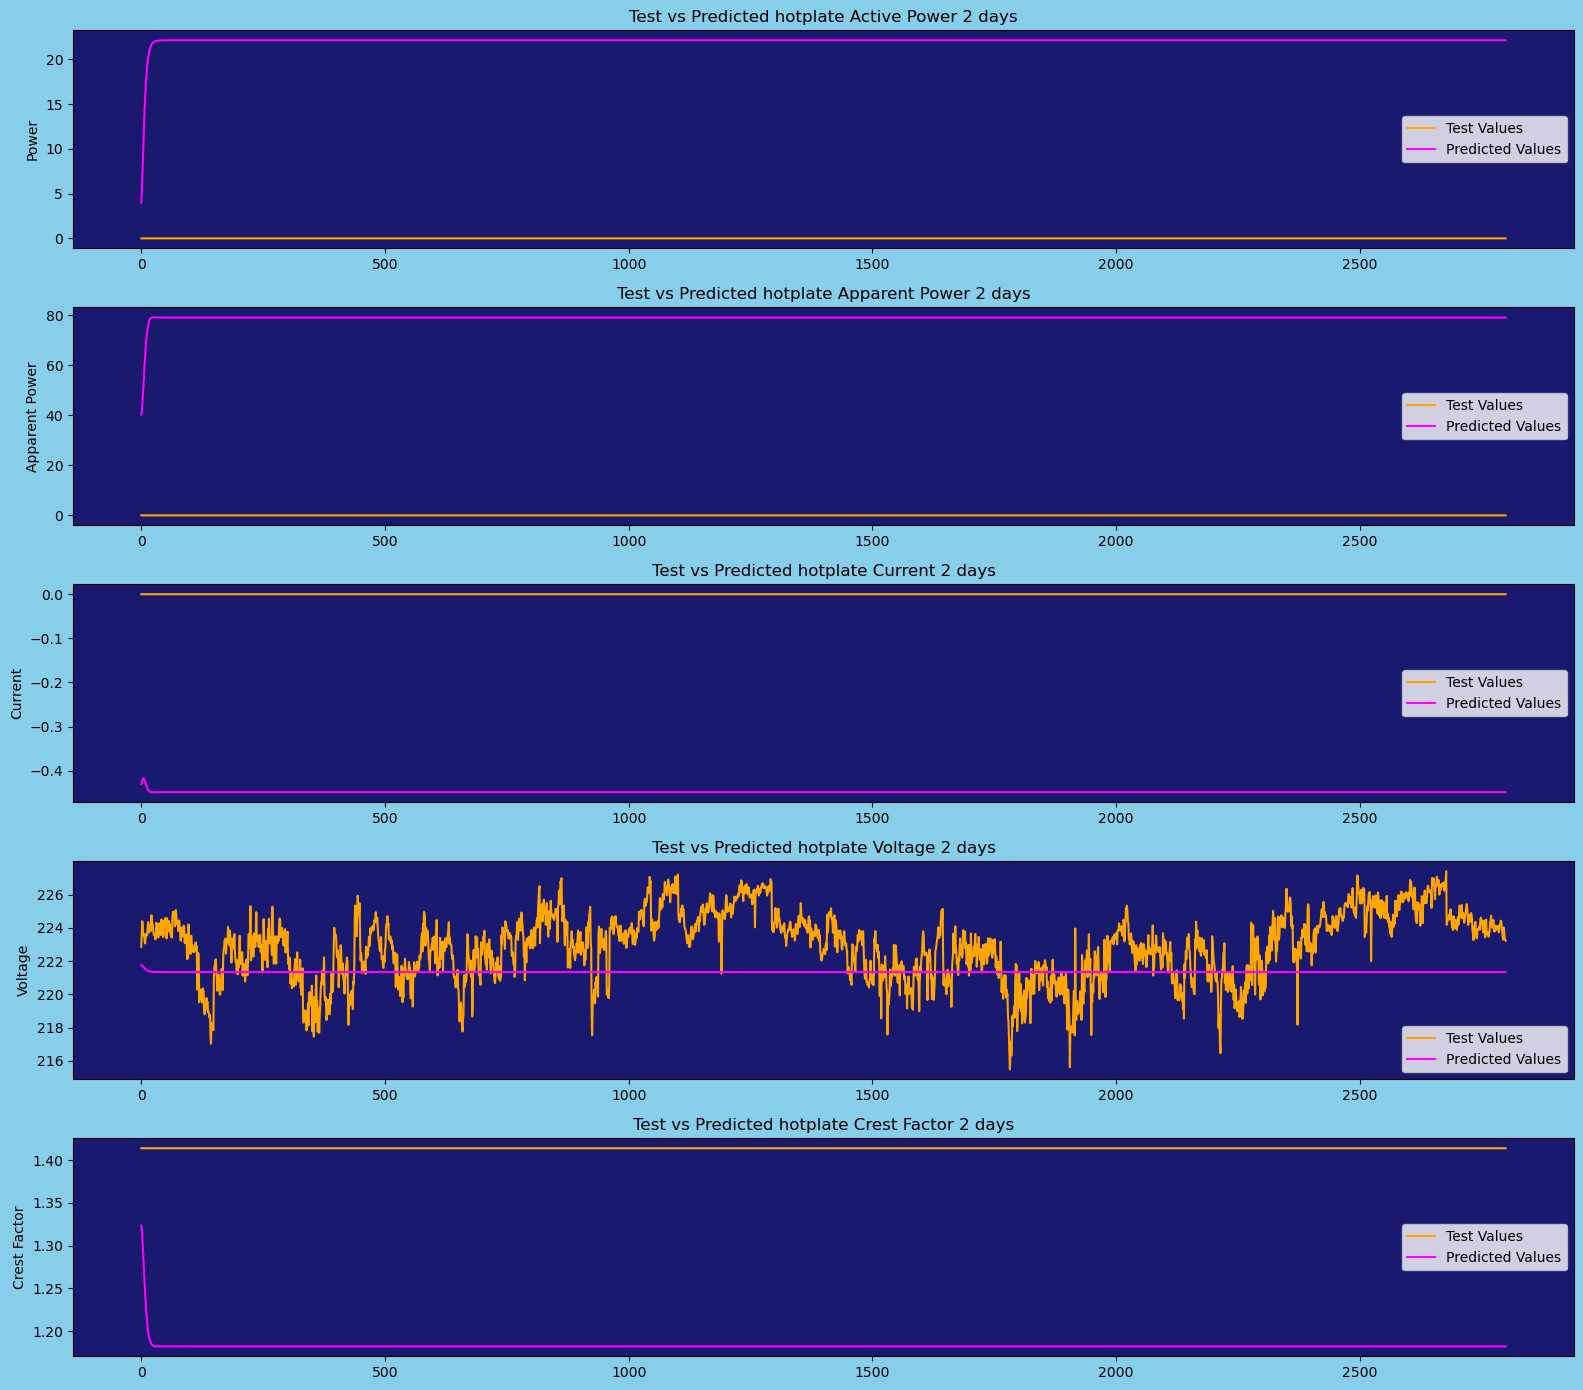

In [7]:
## hotplate ##

import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = hotplate_test['pwrA'].iloc[:2800].values
apwrA = hotplate_test['apwrA'].iloc[:2800].values
curA = hotplate_test['curA'].iloc[:2800].values
vltA = hotplate_test['vltA'].iloc[:2800].values
screA =hotplate_test['screA'].iloc[:2800].values

predicted_pwrA = true_predictions_hotplate['predicted_hotplate_active_power'].values
predicted_apwrA = true_predictions_hotplate['predicted_hotplate_apparent_power'].values
predicted_curA = true_predictions_hotplate['predicted_hotplate_current'].values
predicted_vltA = true_predictions_hotplate['predicted_hotplate_voltage'].values
predicted_screA = true_predictions_hotplate['predicted_hotplate_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted hotplate Active Power 2 days')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted hotplate Apparent Power 2 days')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted hotplate Current 2 days')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted hotplate Voltage 2 days')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted hotplate Crest Factor 2 days')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [12]:
losses = history_hotplate.history['loss']
mae_losses = history_hotplate.history['mae']
mse_losses = history_hotplate.history['mse']

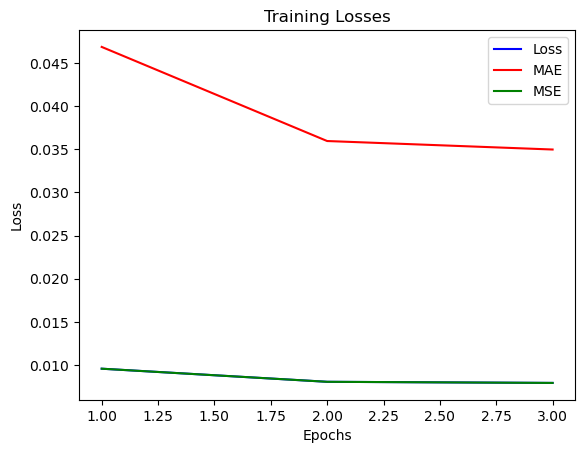

In [15]:
epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, 'b', label='Loss')
plt.plot(epochs, mae_losses, 'r', label='MAE')
plt.plot(epochs, mse_losses, 'g', label='MSE')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

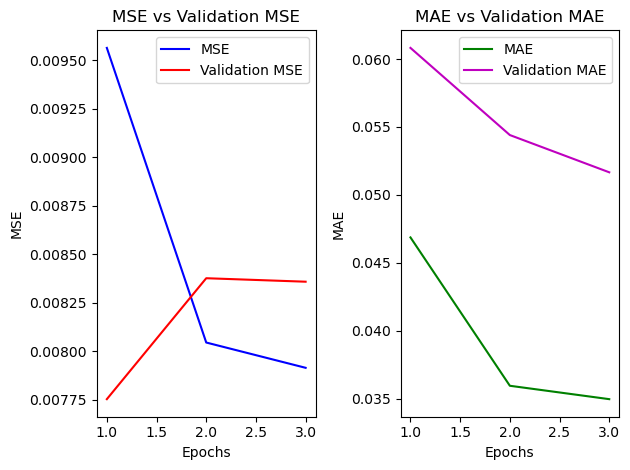

In [16]:
losses = history_hotplate.history['loss']
mae_losses = history_hotplate.history['mae']
mse_losses = history_hotplate.history['mse']
val_mae_losses = history_hotplate.history['val_mae']
val_mse_losses = history_hotplate.history['val_mse']

# Plotting MSE
plt.subplot(1, 2, 1)
epochs = range(1, len(losses) + 1)
plt.plot(epochs, mse_losses, 'b', label='MSE')
plt.plot(epochs, val_mse_losses, 'r', label='Validation MSE')
plt.title('MSE vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae_losses, 'g', label='MAE')
plt.plot(epochs, val_mae_losses, 'm', label='Validation MAE')
plt.title('MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# let us begin with dishwasher data again 5 last training days (september ) to predict 2 first of October
dishwasher_scaled_train = dishwasher_scaled_train[-7200:,:]
dishwasher_scaled_test = dishwasher_scaled_test[:2880,:]
from tensorflow.keras.callbacks import ModelCheckpoint

length = 30 # ~ 1/2 hour

batch_size = 5

train_generator_dishwasher = TimeseriesGenerator(aggregated_scaled_train, dishwasher_scaled_train , length=length, batch_size=batch_size)
validation_generator_dishwasher = TimeseriesGenerator(aggregated_scaled_test, dishwasher_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_dishwasher = Sequential()
model_dishwasher.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_dishwasher.add(LSTM(32, return_sequences= True))
model_dishwasher.add(Dropout(0.5))
model_dishwasher.add(LSTM(8))
model_dishwasher.add(Dropout(0.5))
model_dishwasher.add(Dense(5))

model_dishwasher.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model_dishwasher.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("model_dishwasher_checkpoint.h5", save_best_only=True)

# Train the model
history_dishwasher = model_dishwasher.fit(train_generator_dishwasher, epochs=4, validation_data=validation_generator_dishwasher, callbacks=[early_stop,checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            17920     
                                                                 
 lstm_7 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout_4 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-trai

2023-06-17 02:57:26.157383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:57:26.576314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:57:26.715737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:57:26.907705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 02:57:27.123749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0295 - mae: 0.0882

2023-06-17 03:16:15.913624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 03:16:16.065311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 03:16:16.147552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - 1165s 811ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.0882 - val_loss: 0.0512 - val_mse: 0.0512 - val_mae: 0.1042
Epoch 2/4
1434/1434 [==============================] - 1765s 1s/step - loss: 0.0248 - mse: 0.0248 - mae: 0.0779 - val_loss: 0.0528 - val_mse: 0.0528 - val_mae: 0.1023
Epoch 3/4
1434/1434 [==============================] - 1187s 828ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.0775 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1033


In [28]:
model_dishwasher.save('/Users/evangelosgeraridis/Desktop/MEAZON/models')
model_dishwasher.save('/Users/evangelosgeraridis/Desktop/MEAZON/models/model_dishwasher.h5')
n_features_wh = 5  # Number of aggregated features

test_predictions_wh = []


first_eval_batch_wh = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_wh = first_eval_batch_wh.reshape((1, length, n_features_wh))

current_batch_wh = first_eval_batch_wh

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_wh = model_dishwasher.predict(current_batch_wh)[0]

    

    # Store the actual prediction
    test_predictions_wh.append(current_pred_wh)

    # Update the batch to include the prediction and drop the first value
    current_batch_wh = np.append(current_batch_wh[:, 1:, :], [[current_pred_wh]], axis=1)

INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets


INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets
2023-06-17 04:35:28.900336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 04:35:29.091235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 74ms/step


2023-06-17 04:35:29.188614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 73ms/step


In [29]:
test_predictions_wh = pd.DataFrame(test_predictions_wh)
true_predictions_dishwasher = scaler.inverse_transform(test_predictions_wh)
true_predictions_dishwasher = pd.DataFrame(true_predictions_dishwasher)

true_predictions_dishwasher.columns = ['predicted_dishwasher_active_power','predicted_dishwasher_apparent_power','predicted_dishwasher_current', 'predicted_dishwasher_voltage', 'predicted_dishwasher_crest_factor']
true_predictions_dishwasher

predicted_dishwasher_active_power  predicted_dishwasher_apparent_power   
0                             76.966217                            -1.107926  \
1                             78.223473                             3.200948   
2                             79.959351                            11.199195   
3                             81.344131                            21.128162   
4                             81.826569                            31.261866   
...                                 ...                                  ...   
2795                        -171.761200                          -430.363037   
2796                        -171.761230                          -430.363098   
2797                        -171.761200                          -430.363159   
2798                        -171.761139                          -430.363098   
2799                        -171.761139                          -430.363159   

      predicted_dishwasher_current  predicted_dishwasher_voltage   
0                         0.267277                    223.133255  \
1                         0.272600                    223.099335   
2                         0.281767                    223.027573   
3                         0.291508                    222.924683   
4                         0.298505                    222.799850   
...                            ...                           ...   
2795                     -3.390850                    208.809280   
2796                     -3.390849                    208.809280   
2797                     -3.390849                    208.809280   
2798                     -3.390849                    208.809280   
2799                     -3.390849                    208.809280   

      predicted_dishwasher_crest_factor  
0                              0.775545  
1                              0.775030  
2                              0.774202  
3                              0.773422  
4                              0.773036  
...                                 ...  
2795                           0.908385  
2796                           0.908385  
2797                           0.908385  
2798                           0.908385  
2799                           0.908385  

[2800 rows x 5 columns]

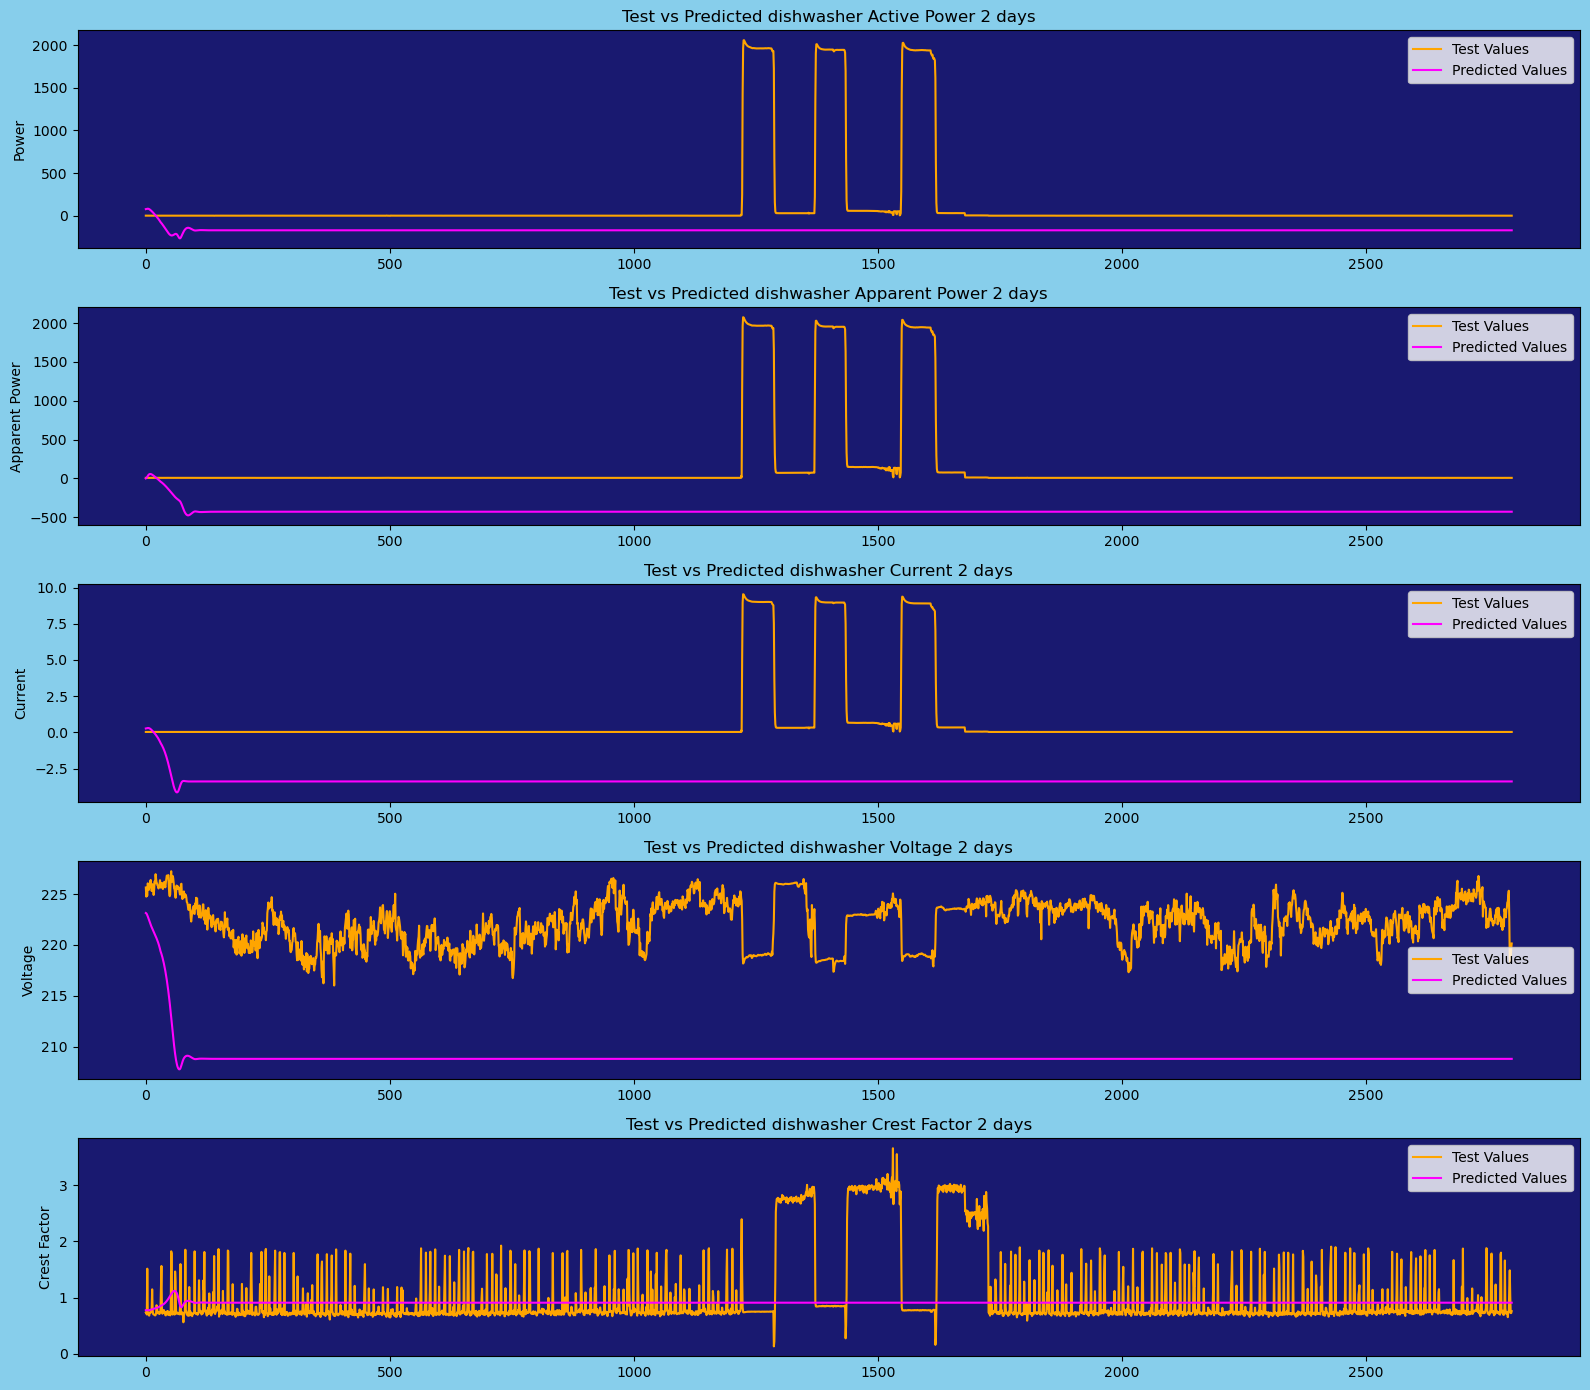

In [30]:
## dishwasher ##

import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = dishwasher_test['pwrA'].iloc[:2800].values
apwrA = dishwasher_test['apwrA'].iloc[:2800].values
curA = dishwasher_test['curA'].iloc[:2800].values
vltA = dishwasher_test['vltA'].iloc[:2800].values
screA =dishwasher_test['screA'].iloc[:2800].values

predicted_pwrA = true_predictions_dishwasher['predicted_dishwasher_active_power'].values
predicted_apwrA = true_predictions_dishwasher['predicted_dishwasher_apparent_power'].values
predicted_curA = true_predictions_dishwasher['predicted_dishwasher_current'].values
predicted_vltA = true_predictions_dishwasher['predicted_dishwasher_voltage'].values
predicted_screA = true_predictions_dishwasher['predicted_dishwasher_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted dishwasher Active Power 2 days')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted dishwasher Apparent Power 2 days')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted dishwasher Current 2 days')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted dishwasher Voltage 2 days')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted dishwasher Crest Factor 2 days')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

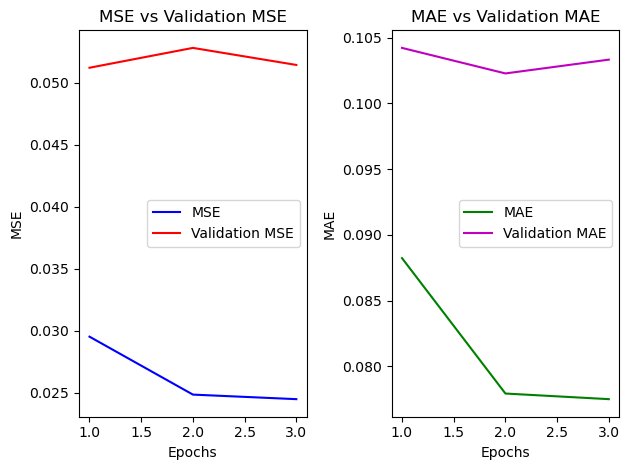

In [31]:
losses = history_dishwasher.history['loss']
mae_losses = history_dishwasher.history['mae']
mse_losses = history_dishwasher.history['mse']
val_mae_losses = history_dishwasher.history['val_mae']
val_mse_losses = history_dishwasher.history['val_mse']

# Plotting MSE
plt.subplot(1, 2, 1)
epochs = range(1, len(losses) + 1)
plt.plot(epochs, mse_losses, 'b', label='MSE')
plt.plot(epochs, val_mse_losses, 'r', label='Validation MSE')
plt.title('MSE vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae_losses, 'g', label='MAE')
plt.plot(epochs, val_mae_losses, 'm', label='Validation MAE')
plt.title('MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# let us begin with water_heater data again 5 last training days (september ) to predict 2 first of October
aggregated_scaled_train = aggregated_scaled_train[-7200:,:]
aggregated_scaled_test = aggregated_scaled_test[:2880,:]
water_heater_scaled_train = water_heater_scaled_train[-7200:,:]
water_heater_scaled_test = water_heater_scaled_test[:2880,:]
from tensorflow.keras.callbacks import ModelCheckpoint

length = 30 # ~ 1/2 hour

batch_size = 5

train_generator_water_heater = TimeseriesGenerator(aggregated_scaled_train, water_heater_scaled_train , length=length, batch_size=batch_size)
validation_generator_water_heater = TimeseriesGenerator(aggregated_scaled_test, water_heater_scaled_test, length=length, batch_size=batch_size)


# Build the RNN model
model_water_heater = Sequential()
model_water_heater.add(LSTM(64, activation='relu', input_shape=(length, 5), return_sequences=True))
model_water_heater.add(LSTM(32, return_sequences= True))
model_water_heater.add(Dropout(0.5))
model_water_heater.add(LSTM(8))
model_water_heater.add(Dropout(0.5))
model_water_heater.add(Dense(5))

model_water_heater.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model_water_heater.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint = ModelCheckpoint("model_water_heater_checkpoint.h5", save_best_only=True)

# Train the model
history_water_heater = model_water_heater.fit(train_generator_water_heater, epochs=4, validation_data=validation_generator_water_heater, callbacks=[early_stop,checkpoint])

Metal device set to: Apple M1


2023-06-17 05:46:11.904192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-17 05:46:11.904862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 31,693
Trainable params: 31,693
Non-traina

2023-06-17 05:46:12.675457: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-17 05:46:14.203146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 05:46:14.981506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 05:46:15.364575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 05:46:15.758015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 05:46:16.232088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045 - mae: 0.0380

2023-06-17 06:20:29.948700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 06:20:30.157571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 06:20:30.274160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1434/1434 [==============================] - 2112s 1s/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0380 - val_loss: 0.1354 - val_mse: 0.1354 - val_mae: 0.3093
Epoch 2/4
1434/1434 [==============================] - 2029s 1s/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0264 - val_loss: 0.1275 - val_mse: 0.1275 - val_mae: 0.2994
Epoch 3/4
1434/1434 [==============================] - 2029s 1s/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0241 - val_loss: 0.1310 - val_mse: 0.1310 - val_mae: 0.3042
Epoch 4/4
1434/1434 [==============================] - 2037s 1s/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0225 - val_loss: 0.1350 - val_mse: 0.1350 - val_mae: 0.3079


In [6]:
model_water_heater.save('/Users/evangelosgeraridis/Desktop/MEAZON/models')
model_water_heater.save('/Users/evangelosgeraridis/Desktop/MEAZON/models/model_water_heater.h5')
n_features_wh = 5  # Number of aggregated features

test_predictions_wh = []


first_eval_batch_wh = aggregated_scaled_train[-length:]   # Select the aggregated features
first_eval_batch_wh = first_eval_batch_wh.reshape((1, length, n_features_wh))

current_batch_wh = first_eval_batch_wh

for i in range(2800):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_wh = model_water_heater.predict(current_batch_wh)[0]

    

    # Store the actual prediction
    test_predictions_wh.append(current_pred_wh)

    # Update the batch to include the prediction and drop the first value
    current_batch_wh = np.append(current_batch_wh[:, 1:, :], [[current_pred_wh]], axis=1)

INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets


INFO:tensorflow:Assets written to: /Users/evangelosgeraridis/Desktop/MEAZON/models/assets
2023-06-17 13:38:15.500294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 13:38:15.711028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-17 13:38:15.823705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 72ms/step


In [7]:
test_predictions_wh = pd.DataFrame(test_predictions_wh)
true_predictions_water_heater = scaler.inverse_transform(test_predictions_wh)
true_predictions_water_heater = pd.DataFrame(true_predictions_water_heater)

true_predictions_water_heater.columns = ['predicted_water_heater_active_power','predicted_water_heater_apparent_power','predicted_water_heater_current', 'predicted_water_heater_voltage', 'predicted_water_heater_crest_factor']
true_predictions_water_heater

predicted_water_heater_active_power   
0                               24.280935  \
1                               24.500015   
2                               24.614237   
3                               24.447142   
4                               23.933601   
...                                   ...   
2795                            11.541121   
2796                            11.541121   
2797                            11.541121   
2798                            11.541121   
2799                            11.541121   

      predicted_water_heater_apparent_power  predicted_water_heater_current   
0                                 28.531940                       -0.048207  \
1                                 28.728821                       -0.047990   
2                                 28.991102                       -0.046217   
3                                 29.203461                       -0.042836   
4                                 29.266239                       -0.038591   
...                                     ...                             ...   
2795                              21.168209                       -0.050221   
2796                              21.168209                       -0.050221   
2797                              21.168209                       -0.050221   
2798                              21.168209                       -0.050221   
2799                              21.168209                       -0.050221   

      predicted_water_heater_voltage  predicted_water_heater_crest_factor  
0                         218.605621                             1.677741  
1                         218.620850                             1.677999  
2                         218.624680                             1.677864  
3                         218.601959                             1.677536  
4                         218.548904                             1.677442  
...                              ...                                  ...  
2795                      217.271225                             1.712048  
2796                      217.271225                             1.712048  
2797                      217.271225                             1.712048  
2798                      217.271225                             1.712048  
2799                      217.271225                             1.712048  

[2800 rows x 5 columns]

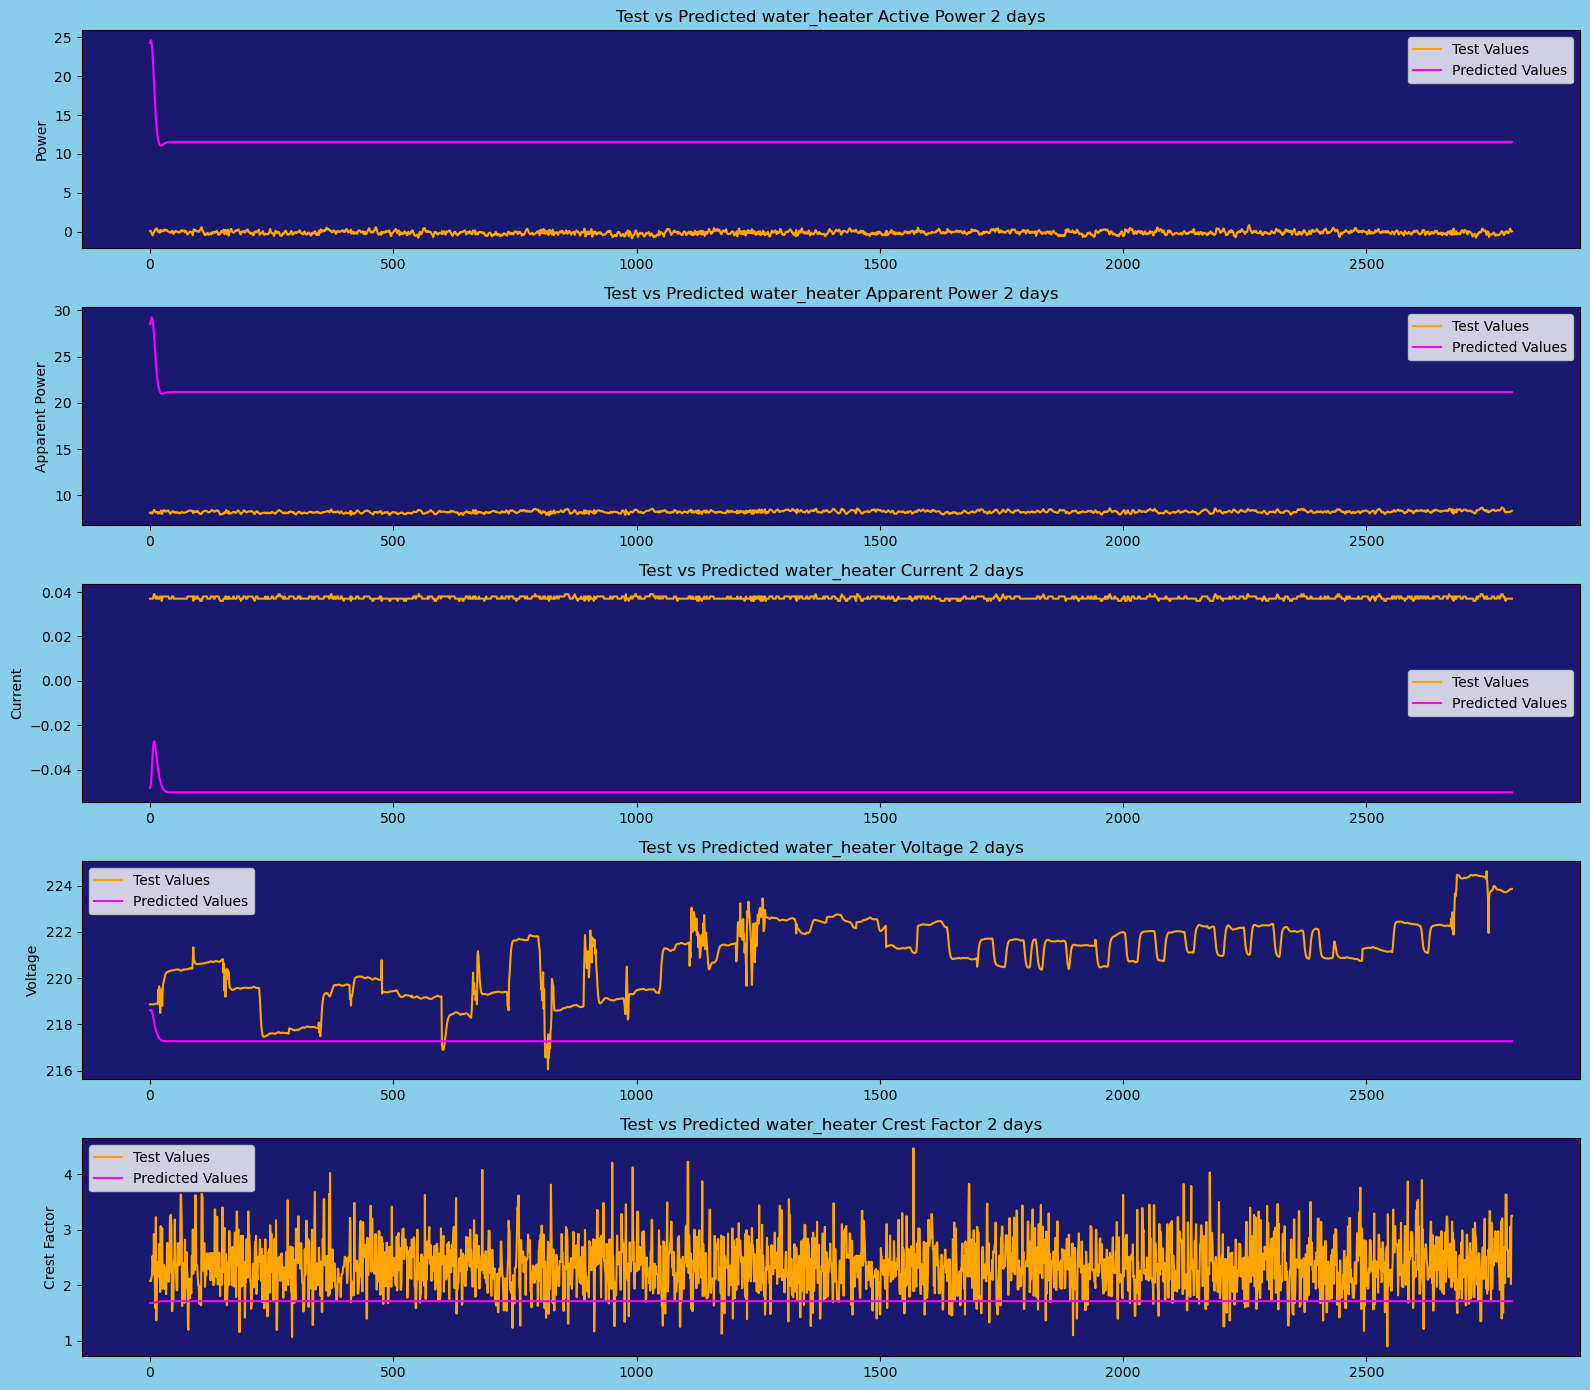

In [9]:
## water_heater ##

import matplotlib.pyplot as plt

# Extract the columns from the datasets
pwrA = water_heater_test['pwrC'].iloc[:2800].values
apwrA = water_heater_test['apwrC'].iloc[:2800].values
curA = water_heater_test['curC'].iloc[:2800].values
vltA = water_heater_test['vltC'].iloc[:2800].values
screA =water_heater_test['screC'].iloc[:2800].values

predicted_pwrA = true_predictions_water_heater['predicted_water_heater_active_power'].values
predicted_apwrA = true_predictions_water_heater['predicted_water_heater_apparent_power'].values
predicted_curA = true_predictions_water_heater['predicted_water_heater_current'].values
predicted_vltA = true_predictions_water_heater['predicted_water_heater_voltage'].values
predicted_screA = true_predictions_water_heater['predicted_water_heater_crest_factor'].values

# Create subplots for each column
fig, axs = plt.subplots(5, 1, figsize=(16, 14))
fig.patch.set_facecolor('skyblue')
for ax in axs:
    ax.set_facecolor('midnightblue')

    
    
# Plot predicted vs test for each column
axs[0].plot(pwrA, label='Test Values', color = 'orange')
axs[0].plot(predicted_pwrA, label='Predicted Values', color = 'magenta')
axs[0].set_ylabel('Power')
axs[0].set_title('Test vs Predicted water_heater Active Power 2 days')
axs[0].legend()

axs[1].plot(apwrA, label='Test Values', color = 'orange')
axs[1].plot(predicted_apwrA, label='Predicted Values',color = 'magenta')
axs[1].set_ylabel('Apparent Power')
axs[1].set_title('Test vs Predicted water_heater Apparent Power 2 days')
axs[1].legend()

axs[2].plot(curA, label='Test Values', color = 'orange')
axs[2].plot(predicted_curA, label='Predicted Values',color = 'magenta')
axs[2].set_ylabel('Current')
axs[2].set_title('Test vs Predicted water_heater Current 2 days')
axs[2].legend()

axs[3].plot(vltA, label='Test Values', color = 'orange')
axs[3].plot(predicted_vltA, label='Predicted Values',color = 'magenta')
axs[3].set_ylabel('Voltage')
axs[3].set_title('Test vs Predicted water_heater Voltage 2 days')
axs[3].legend()

axs[4].plot(screA, label='Test Values', color = 'orange')
axs[4].plot(predicted_screA, label='Predicted Values',color = 'magenta')
axs[4].set_ylabel('Crest Factor')
axs[4].set_title('Test vs Predicted water_heater Crest Factor 2 days')
axs[4].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

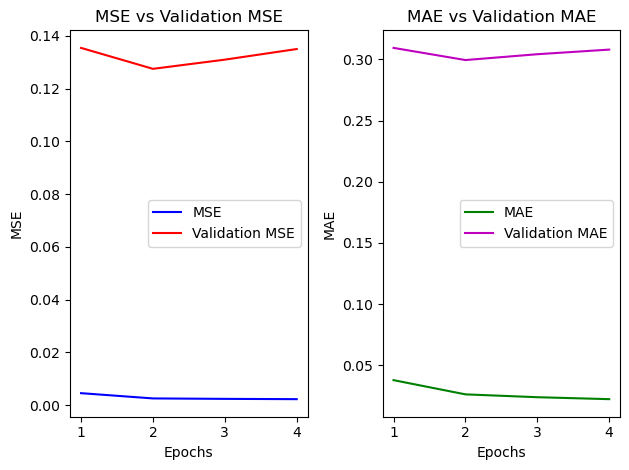

In [10]:
losses = history_water_heater.history['loss']
mae_losses = history_water_heater.history['mae']
mse_losses = history_water_heater.history['mse']
val_mae_losses = history_water_heater.history['val_mae']
val_mse_losses = history_water_heater.history['val_mse']

# Plotting MSE
plt.subplot(1, 2, 1)
epochs = range(1, len(losses) + 1)
plt.plot(epochs, mse_losses, 'b', label='MSE')
plt.plot(epochs, val_mse_losses, 'r', label='Validation MSE')
plt.title('MSE vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae_losses, 'g', label='MAE')
plt.plot(epochs, val_mae_losses, 'm', label='Validation MAE')
plt.title('MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()